In [1]:
import numpy as np1
import matplotlib.pyplot as plt
import seaborn as sns
import librosa as lb
import librosa.display
import os

import IPython
import IPython.display as ipd

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers, models, optimizers, losses, regularizers
from tensorflow.keras.layers.experimental import preprocessing

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import visualkeras
import pandas as pd

In [2]:
 print(np1.__version__)

1.24.3


In [3]:
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  0


In [4]:
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'


In [5]:
path = 'D:/Master/ArtificialIntelligence/archive/Data/features_3_sec.csv'
data = pd.read_csv(path)
data.head()

,filename,length,chroma_stft_mean,chroma_stft_var,rms_mean,rms_var,spectral_centroid_mean,spectral_centroid_var,spectral_bandwidth_mean,spectral_bandwidth_var,...,mfcc16_var,mfcc17_mean,mfcc17_var,mfcc18_mean,mfcc18_var,mfcc19_mean,mfcc19_var,mfcc20_mean,mfcc20_var,label
0,blues.00000.0.wav,66149,0.335406,0.091048,0.130405,0.003521,1773.065032,167541.630869,1972.744388,117335.771563,...,39.687145,-3.241280,36.488243,0.722209,38.099152,-5.050335,33.618073,-0.243027,43.771767,blues
1,blues.00000.1.wav,66149,0.343065,0.086147,0.112699,0.001450,1816.693777,90525.690866,2010.051501,65671.875673,...,64.748276,-6.055294,40.677654,0.159015,51.264091,-2.837699,97.030830,5.784063,59.943081,blues
2,blues.00000.2.wav,66149,0.346815,0.092243,0.132003,0.004620,1788.539719,111407.437613,2084.565132,75124.921716,...,67.336563,-1.768610,28.348579,2.378768,45.717648,-1.938424,53.050835,2.517375,33.105122,blues
3,blues.00000.3.wav,66149,0.363639,0.086856,0.132565,0.002448,1655.289045,111952.284517,1960.039988,82913.639269,...,47.739452,-3.841155,28.337118,1.218588,34.770935,-3.580352,50.836224,3.630866,32.023678,blues
4,blues.00000.4.wav,66149,0.335579,0.088129,0.143289,0.001701,1630.656199,79667.267654,1948.503884,60204.020268,...,30.336359,0.664582,45.880913,1.689446,51.363583,-3.392489,26.738789,0.536961,29.146694,blues


In [6]:
data.shape

(9990, 60)

In [7]:
data.dtypes

filename                    object
length                       int64
chroma_stft_mean           float64
chroma_stft_var            float64
rms_mean                   float64
rms_var                    float64
spectral_centroid_mean     float64
spectral_centroid_var      float64
spectral_bandwidth_mean    float64
spectral_bandwidth_var     float64
rolloff_mean               float64
rolloff_var                float64
zero_crossing_rate_mean    float64
zero_crossing_rate_var     float64
harmony_mean               float64
harmony_var                float64
perceptr_mean              float64
perceptr_var               float64
tempo                      float64
mfcc1_mean                 float64
mfcc1_var                  float64
mfcc2_mean                 float64
mfcc2_var                  float64
mfcc3_mean                 float64
mfcc3_var                  float64
mfcc4_mean                 float64
mfcc4_var                  float64
mfcc5_mean                 float64
mfcc5_var           

In [8]:
data = data.drop(labels="filename",axis=1)

In [9]:
# Setup: path, one-hot vector for the labels
# ----------------

path = 'D:/Master/ArtificialIntelligence/archive/Data/genres_original/'
labels = [f.name for f in os.scandir(path) if f.is_dir()]

# One-hot vector for the labels
indices = [i for i in range(len(labels))]
depth = len(labels)
oh = tf.one_hot(indices, depth)
oh_dict = {label:np1.array(oh[i,:]) for i, label in enumerate(labels)}

print(labels)
for k, v in oh_dict.items():
    print(k,v)

n_files = 0
for folder in labels:
    files = os.listdir(path+folder)
    for file in files:
        if file.split('.')[-1] == 'wav':
            n_files += 1
print(f'n_files: {n_files}')

['blues', 'classical', 'country', 'disco', 'hiphop', 'jazz', 'metal', 'pop', 'reggae', 'rock']
blues [1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
classical [0. 1. 0. 0. 0. 0. 0. 0. 0. 0.]
country [0. 0. 1. 0. 0. 0. 0. 0. 0. 0.]
disco [0. 0. 0. 1. 0. 0. 0. 0. 0. 0.]
hiphop [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
jazz [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]
metal [0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
pop [0. 0. 0. 0. 0. 0. 0. 1. 0. 0.]
reggae [0. 0. 0. 0. 0. 0. 0. 0. 1. 0.]
rock [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
n_files: 1000


In [10]:
# Global variables
# ----------------

H = 128 # height of the tensor

N_FEATURES = 1 # Channels of the tensor
N_FILES = n_files
AUG_FEATURES = 5
N_SLICES = 3
M = N_FILES * N_SLICES * (AUG_FEATURES + 1) # Number of instances after the feature transform

In [11]:
def read_sample(file):
    y, sr = lb.load(file)
    return y, sr

def listen_sample(sample, sr=44100):
    return IPython.display.display(ipd.Audio(data=sample, rate=sr))


def augment_sample(sample, sr):
    """
    Data augmentation. To prevent overfitting
    Techniques used: pitch shist, time stretch, add noise

    Args:
        sample: usually output of lb.load()
        sr = sampling rate. output from lb.load()
        
    Returns:
        list with each augmented sample as an item of the list
    """
    augmented_samples = list()
    #. 1. Split the sample into smaller samples
    samples = np1.array_split(sample, N_SLICES)
    
    for sample_ in samples:
        # 2. Add the original sample
        augmented_samples.append(sample_)
        # 3. Change pitch
        for n_steps1 in [4,6]:
            augmented_samples.append(lb.effects.pitch_shift(y = sample_, sr = sr, n_steps = n_steps1))

        # 4. Time Stretch
        for rate in [0.5, 2.0]:
            augmented_samples.append(lb.effects.time_stretch(y = sample_, rate = rate))

        # 5. White Noise
        wn = np1.random.randn(len(sample_))
        augmented_samples.append(sample_ + 0.005*wn)
    
    return augmented_samples

def get_input_length(path, folders):
    """
    Get the input length from the first file
    """
    folder = folders[0]
    files = os.listdir(path+folder)
    input_length = 0
    for file in files:
        if file.split('.')[-1] == 'wav':
            sample, sr = read_sample(path+folder+'/'+file)
            input_length = len(sample) // N_SLICES
            break
        
    
    return input_length


def get_n_frames(sample, sr):
    mel = lb.feature.melspectrogram(y=sample, sr=sr)
#     print(mel.shape)
    return mel.shape[1]
    

def read_raw_data(path, folders):
    """
    Read the data from disk and save it in two numpy arrays. 
    Run only once, and then run create_dataset for computing 
    the different features.
    
    Args:
        path: path to where the folders with the audio data is
        folders: list of folders. in this case is the same as the labels
        
    Returns: 
        x_raw: samples plus augmented samples. 
         shape: (N_FILES*AUG_FEATURES, INPUT_LENGTH)
        y_raw: y tensor of the samples and augmented samples
         shape: (N_FILES*AUG_FEATURES, 10) one-hot encoded
    
    """
    input_length = get_input_length(path, folders)
    
    x_raw = np1.zeros((M, input_length))
    y_raw = np1.zeros((M, 10))
    print(x_raw.shape, y_raw.shape)
    i = 0
    for folder in folders:
        print(f"Reading {folder}")
        files = os.listdir(path+folder)
        for file in files:
         if file !='jazz.00054.wav':
            # make sure the file is a .wav file
            if file.split('.')[-1] == 'wav':
                sample, sr = read_sample(path+folder+'/'+file)
                aug_samples = augment_sample(sample, sr)
                for sample_ in aug_samples: 
                    # padding or shorten sample
                    if len(sample_) > input_length:
                        sample_ = sample_[:input_length]
                    else:
                        sample_ = np1.pad(sample_, (0, max(0, input_length - len(sample_))))
                    x_raw[i,:] = sample_
                    y_raw[i,:] = oh_dict[folder]
                    i += 1
    print('Samples read: ', i)
    return x_raw, y_raw, sr
    
def create_dataset(x_raw, sr):
    """
    Args:
        x_raw: Tensor with shape (N_FILES*AUG_FEATURES, INPUT_LENGTH)
        sr: The sr used across the samples. same for all
    
    Returns: 
        X: Tensor(n_files, 128, frames, N_FEATURES). With the features
        already encoded
        
    """
    n_frames = get_n_frames(x_raw[0,:], sr)
    X = np1.zeros((M, 128, n_frames, N_FEATURES))

    for i in range(M):
        sample = x_raw[i,:]
        mel = lb.feature.melspectrogram(y=sample, sr=sr)
        spect = lb.power_to_db(mel, ref=1.0)
        norm_spect = normalize(spect)
        X[i,:,:,0] = norm_spect

                
    return X

In [12]:
# Reading raw data from files
# -------------
# saving it into disk in case we need to load it
# hello everyone
batch_size = 32
x_raw, y_raw, sr = read_raw_data(path, labels)
print(x_raw.shape, y_raw.shape)
#np1.save('D:/Master/ArtificialIntelligence/archive/Data/x_raw_3_slice', x_raw)
#np1.save('D:/Master/ArtificialIntelligence/archive/Data/y_raw_3_slice', y_raw)

(18000, 220598) (18000, 10)
Reading blues
Reading classical
Reading country
Reading disco
Reading hiphop
Reading jazz
Reading metal
Reading pop
Reading reggae
Reading rock
Samples read:  17982
(18000, 220598) (18000, 10)


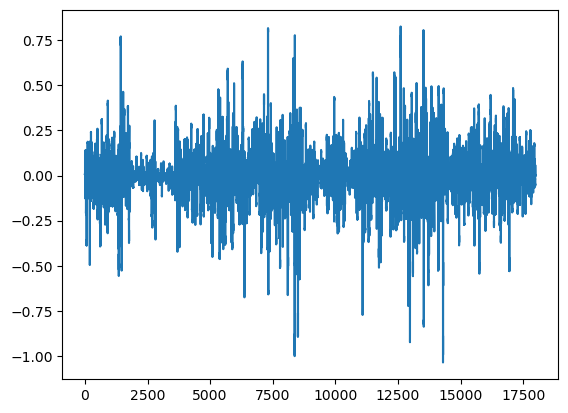

In [13]:
plt.plot(x_raw[:,0])

In [ ]:
# np1.save('D:/Master/ArtificialIntelligence/archive/Data/x_raw_3_slice', x_raw)
# np1.save('D:/Master/ArtificialIntelligence/archive/Data/y_raw_3_slice', y_raw)

In [ ]:
# Run only if we are loading the data

x_raw = np1.load('D:/Master/ArtificialIntelligence/archive/Data/x_raw_3_slice.npy')
y_raw = np1.load('D:/Master/ArtificialIntelligence/archive/Data/y_raw_3_slice.npy')
_,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [14]:
_,sr = read_sample(path+'blues/'+'blues.00000.wav')

In [15]:
# Creating the tensor with the features
# -----------
print(sr)
X = create_dataset(x_raw, sr)
Y = np1.copy(y_raw)
print(X.shape)
print(Y.shape)

22050
(18000, 128, 431, 1)
(18000, 10)


In [16]:
assert X.shape[0] == Y.shape[0], "X, Y shapes don't match"
assert Y.shape[1] == len(labels), "Y shape doesn't match the shape of the labels"

In [17]:
# Train, validation, test split
# ------------
# 80% for training, 10% for validation and 10% for testing

x_train, x_test_valid, y_train, y_test_valid = train_test_split(X,Y, train_size=0.8)
x_val, x_test, y_val, y_test = train_test_split(x_test_valid,y_test_valid, test_size=0.5)

print(f'Train: {x_train.shape} {y_train.shape}')
print(f'Valid: {x_val.shape}   {y_val.shape}')
print(f'Test:  {x_test.shape}  {y_test.shape}')

Train: (14400, 128, 431, 1) (14400, 10)
Valid: (1800, 128, 431, 1)   (1800, 10)
Test:  (1800, 128, 431, 1)  (1800, 10)


In [18]:
# LeNet-5
# -----
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 

x = layers.Conv2D(8, (3,3), activation='relu')(inputs)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Conv2D(16, (3,3), activation='relu')(x)
x = layers.AveragePooling2D()(x)
x = layers.Dropout(0.2)(x)
x = layers.Flatten()(x)

x = layers.Dense(120, activation='relu')(x)
x = layers.Dropout(0.3)(x)
x = layers.Dense(84, activation='relu')(x)
x = layers.Dropout(0.4)(x)
outputs = layers.Dense(10, activation = 'softmax')(x)

In [19]:
lenet = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
lenet.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
lenet.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 conv2d (Conv2D)             (None, 126, 429, 8)       80        
                                                                 
 average_pooling2d (Average  (None, 63, 214, 8)        0         
 Pooling2D)                                                      
                                                                 
 dropout (Dropout)           (None, 63, 214, 8)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 212, 16)       1168      
                                                                 
 average_pooling2d_1 (Avera  (None, 30, 106, 16)       0         
 gePooling2D)                                                

In [20]:
epochs = 20

history_lenet = lenet.fit(x=x_train, 
                          y=y_train,
                          validation_data=(x_val, y_val),
                          epochs=epochs,
                          shuffle=True)

Epoch 1/20


450/450 [==============================] - 130s 163ms/step - loss: 1.9904 - accuracy: 0.2600 - val_loss: 1.6517 - val_accuracy: 0.4194
Epoch 2/20
450/450 [==============================] - 61s 137ms/step - loss: 1.5585 - accuracy: 0.4328 - val_loss: 1.3224 - val_accuracy: 0.5356
Epoch 3/20
450/450 [==============================] - 61s 136ms/step - loss: 1.3120 - accuracy: 0.5247 - val_loss: 1.1481 - val_accuracy: 0.5778
Epoch 4/20
450/450 [==============================] - 61s 135ms/step - loss: 1.1085 - accuracy: 0.6038 - val_loss: 0.9974 - val_accuracy: 0.6633
Epoch 5/20
450/450 [==============================] - 61s 136ms/step - loss: 0.9301 - accuracy: 0.6676 - val_loss: 0.9090 - val_accuracy: 0.6972
Epoch 6/20
450/450 [==============================] - 61s 135ms/step - loss: 0.7885 - accuracy: 0.7217 - val_loss: 0.9014 - val_accuracy: 0.7022
Epoch 7/20
450/450 [==============================] - 61s 135ms/step - loss: 0.6868 - accuracy: 0.7587 - val_loss: 0.9464 - val

In [21]:
lenet.evaluate(x=x_test, y=y_test)

57/57 [==============================] - 1s 21ms/step - loss: 0.9598 - accuracy: 0.7594


[0.9597936272621155, 0.7594444155693054]

57/57 [==============================] - 1s 24ms/step


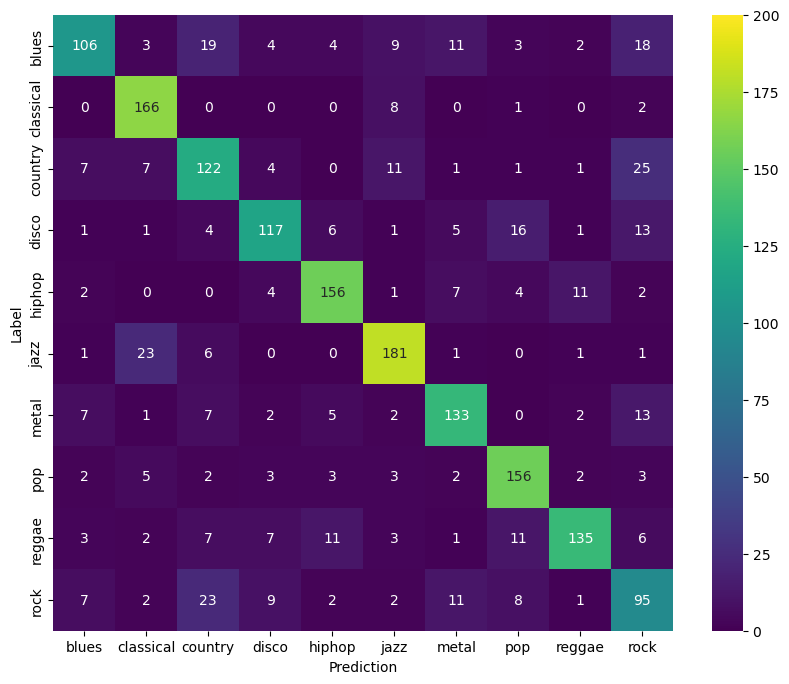

In [23]:
# HeatMap LeNet 

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(lenet.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("D:/Master/ArtificialIntelligence/archive/Data/png/lenet_confmatrix.png", dpi=150)
plt.show()

In [ ]:
plt.rcParams["axes.prop_cycle"] = plt.cycler("color", plt.cm.Set1.colors)

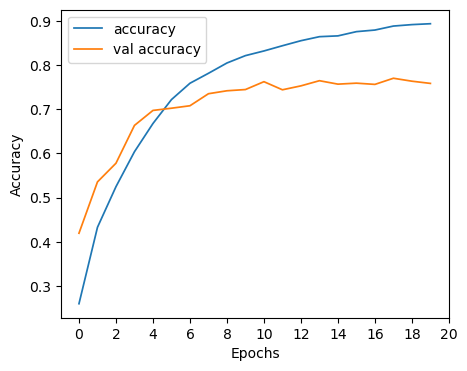

In [24]:
fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), history_lenet.history['accuracy'], label='accuracy', lw=1.25)
ax.plot(range(epochs), history_lenet.history['val_accuracy'], label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,2)])
ax.legend()
plt.savefig("D:/Master/ArtificialIntelligence/archive/Data/png/lenet_acc_epochs.png", dpi=150)

plt.show()

In [25]:
# CNN-64 Resizing + FC
# --------

n_filters = 64
input_shape = (X.shape[1], X.shape[2], X.shape[3])
inputs = keras.Input(shape=input_shape) 
x = preprocessing.Resizing(128, 128)(inputs)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, 3, activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)


x = layers.Flatten()(x)
x = layers.Dense(128, activation='relu')(x)
x = layers.Dropout(0.4)(x)

outputs = layers.Dense(10, activation='softmax')(x)

In [27]:

# Original
# ---------

n_filters = 64
inputs = keras.Input(shape=input_shape) 
x = layers.Conv2D(n_filters, (3,3), activation='relu')(inputs)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.2)(x)

x = layers.Conv2D(n_filters, (3,3), activation='relu')(x)
x = layers.MaxPooling2D((2,2))(x)
x = layers.Dropout(0.3)(x)

x = layers.Flatten()(x)
outputs = layers.Dense(10, activation='softmax')(x)

In [28]:
# Building the model. Compiling
# --------------
# Loss: Categorical Cross Entropy, since we have one-hot vectors. 

model = models.Model(inputs = inputs, outputs=outputs)
optimizer = optimizers.Adam(learning_rate = 0.001)
model.compile(optimizer, loss=losses.CategoricalCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_4 (InputLayer)        [(None, 128, 431, 1)]     0         
                                                                 
 conv2d_9 (Conv2D)           (None, 126, 429, 64)      640       
                                                                 
 max_pooling2d_7 (MaxPoolin  (None, 63, 214, 64)       0         
 g2D)                                                            
                                                                 
 dropout_12 (Dropout)        (None, 63, 214, 64)       0         
                                                                 
 conv2d_10 (Conv2D)          (None, 61, 212, 64)       36928     
                                                                 
 max_pooling2d_8 (MaxPoolin  (None, 30, 106, 64)       0         
 g2D)                                                      

In [29]:
epochs = 20

history = model.fit(x=x_train, 
                    y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=epochs,
                    shuffle=True)

Epoch 1/20
450/450 [==============================] - 581s 1s/step - loss: 1.7915 - accuracy: 0.3533 - val_loss: 1.4131 - val_accuracy: 0.5139
Epoch 2/20
450/450 [==============================] - 533s 1s/step - loss: 1.2743 - accuracy: 0.5521 - val_loss: 1.1617 - val_accuracy: 0.5972
Epoch 3/20
450/450 [==============================] - 529s 1s/step - loss: 1.0190 - accuracy: 0.6472 - val_loss: 1.0613 - val_accuracy: 0.6239
Epoch 4/20
450/450 [==============================] - 530s 1s/step - loss: 0.8311 - accuracy: 0.7135 - val_loss: 0.8889 - val_accuracy: 0.7039
Epoch 5/20
450/450 [==============================] - 529s 1s/step - loss: 0.7009 - accuracy: 0.7570 - val_loss: 0.8033 - val_accuracy: 0.7489
Epoch 6/20
450/450 [==============================] - 527s 1s/step - loss: 0.5961 - accuracy: 0.7939 - val_loss: 0.7624 - val_accuracy: 0.7578
Epoch 7/20
450/450 [==============================] - 526s 1s/step - loss: 0.5239 - accuracy: 0.8175 - val_loss: 0.7469 - val_accuracy: 0.7761

In [33]:
model.evaluate(x=x_test, y=y_test)

57/57 [==============================] - 10s 173ms/step - loss: 0.5566 - accuracy: 0.8556


[0.5566216111183167, 0.855555534362793]

57/57 [==============================] - 10s 164ms/step


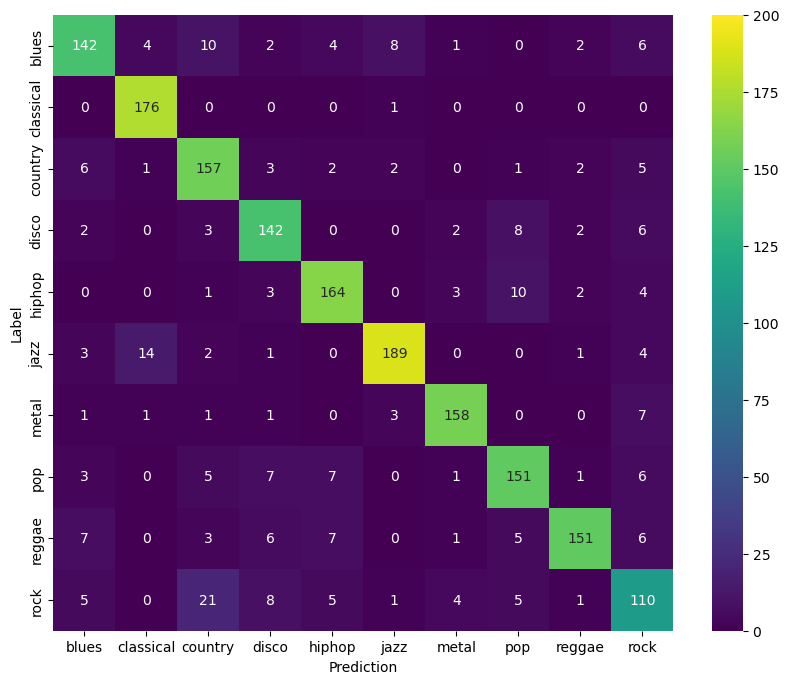

In [34]:
# HeatMap CNN64 filtered

y_true = tf.argmax(y_test, axis=1)
y_pred = tf.argmax(model.predict(x_test), axis=1)

# Have to be 1-D vectors. Not one-hot encoded
confusion_mtx = tf.math.confusion_matrix(y_true, y_pred) 
fig, ax = plt.subplots(figsize=(10, 8))
sns.heatmap(confusion_mtx, xticklabels=labels, yticklabels=labels, 
            annot=True, fmt='g', ax=ax, cmap="viridis", vmax=200)
ax.set_xlabel('Prediction')
ax.set_ylabel('Label')
plt.savefig("D:/Master/ArtificialIntelligence/archive/Data/png/cnn64_confmatrix.png", dpi=150)
plt.show()

In [35]:
model.save('D:/Master/ArtificialIntelligence/archive/Data/models/model1')

INFO:tensorflow:Assets written to: D:/Master/ArtificialIntelligence/archive/Data/models/model1\assets


INFO:tensorflow:Assets written to: D:/Master/ArtificialIntelligence/archive/Data/models/model1\assets


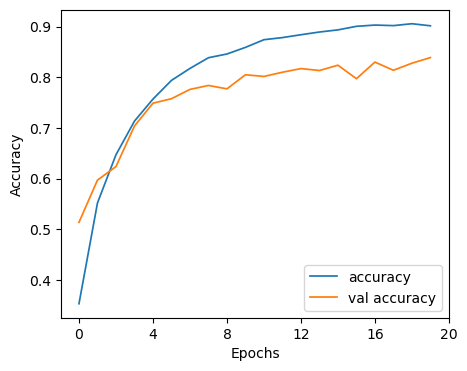

In [38]:
epochs = 20
hist_acc = history.history['accuracy'] 
hist_val_acc = history.history['val_accuracy'] 

fig, ax = plt.subplots(figsize=(5,4))
ax.plot(range(epochs), hist_acc, label='accuracy', lw=1.25)
ax.plot(range(epochs), hist_val_acc, label='val accuracy', lw=1.25)
ax.set_xlabel('Epochs')
ax.set_ylabel('Accuracy')
ax.set_xticks([i for i in range(0, epochs+1,4)])
ax.legend()
plt.savefig("D:/Master/ArtificialIntelligence/archive/Data/png/cnn64_acc_epochs.png", dpi=150)

plt.show()